/home/proffiterol/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0 -> 8, 4, 6, 1
1 -> 0, 8
2 -> 6, 9, 3
3 -> 6, 2
4 -> 0, 6
6 -> 0, 3, 4, 2
7 -> 9
8 -> 0, 1, 9
9 -> 2, 8, 7
Grafo iniziale:


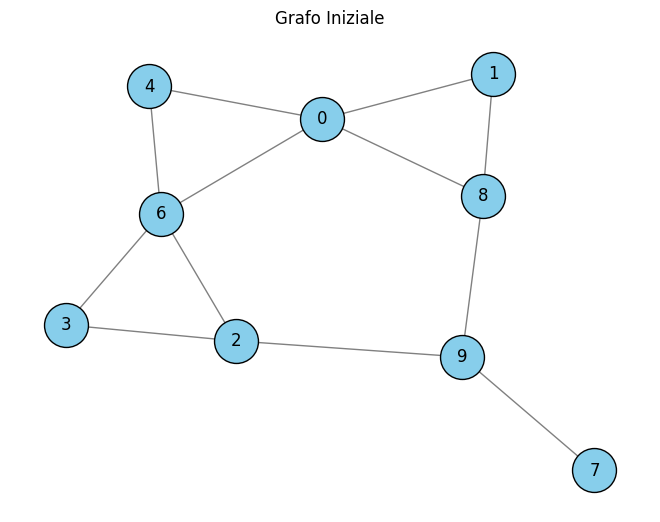

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:00<00:00, 1617.39it/s]
/home/proffiterol/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Assegnazione dei nodi ai cluster:
Nodo 0 appartiene al Cluster 1
Nodo 8 appartiene al Cluster 1
Nodo 4 appartiene al Cluster 1
Nodo 6 appartiene al Cluster 2
Nodo 1 appartiene al Cluster 1
Nodo 2 appartiene al Cluster 2
Nodo 9 appartiene al Cluster 3
Nodo 3 appartiene al Cluster 2
Nodo 7 appartiene al Cluster 4


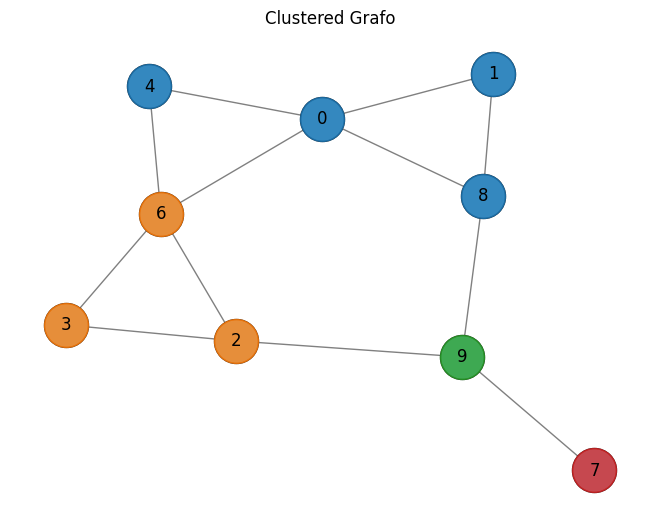

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.cluster import KMeans

def plot_graph(graph, title, filename=None, colors=None):
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color='skyblue', font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)
    
    if colors:
        for i, nodes in enumerate(colors):
            nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=f'C{i}', node_size=1000, alpha=0.8)

    plt.title(title)
    if filename:
        plt.savefig(filename)
    plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)  # Se il grafo è non diretto, aggiungi anche l'arco inverso

    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

if __name__ == "__main__":
    grafo = Graph()

    # Aggiungi i vertici
    grafo.aggiungi_vertice(0)
    grafo.aggiungi_vertice(1)
    grafo.aggiungi_vertice(2)
    grafo.aggiungi_vertice(3)
    grafo.aggiungi_vertice(4)
    grafo.aggiungi_vertice(6)
    grafo.aggiungi_vertice(7)
    grafo.aggiungi_vertice(8)
    grafo.aggiungi_vertice(9)

    # Aggiungi gli archi
    grafo.aggiungi_arco(0, 8)
    grafo.aggiungi_arco(0, 4)
    grafo.aggiungi_arco(0, 6)
    grafo.aggiungi_arco(1, 0)
    grafo.aggiungi_arco(1, 8)
    grafo.aggiungi_arco(6, 3)
    grafo.aggiungi_arco(6, 4)
    grafo.aggiungi_arco(6, 2)
    grafo.aggiungi_arco(2, 9)
    grafo.aggiungi_arco(3, 2)
    grafo.aggiungi_arco(8, 9)
    grafo.aggiungi_arco(9, 7)

    # Stampa il grafo
    grafo.stampa_grafo()

    # Disegno del grafo iniziale
    G_initial = converti_grafo_personalizzato_in_networkx(grafo)
    print("Grafo iniziale:")
    plot_graph(G_initial, "Grafo Iniziale", filename="grafo_iniziale.png")

    # Generazione dell'embedding numerico dei nodi utilizzando node2vec
    node2vec = Node2Vec(G_initial, dimensions=16, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Creazione della matrice di feature per l'algoritmo di k-means
    node_features = np.array([model.wv[str(node)] for node in G_initial.nodes()])

    # Numero di cluster desiderati
    k = 4

    # Applicazione di k-means per ottenere i cluster
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(node_features)
    cluster_labels = kmeans.labels_

    # Assegnazione dei nodi ai cluster
    node_to_cluster = {}
    for node, label in zip(G_initial.nodes(), cluster_labels):
        node_to_cluster[node] = label

    # Stampa l'assegnazione dei nodi ai cluster
    print("\nAssegnazione dei nodi ai cluster:")
    for node, cluster in node_to_cluster.items():
        print(f"Nodo {node} appartiene al Cluster {cluster + 1}")

    # Dividi i nodi in cluster separati
    separated_clusters = [[] for _ in range(k)]
    for node, cluster in node_to_cluster.items():
        separated_clusters[cluster].append(node)

    # Disegna il grafo con colori diversi per le varie partizioni tra nodi
    plot_graph(G_initial, "Clustered Grafo", filename="grafo_clustered.png", colors=separated_clusters)
